In [ ]:
# Import libraries

# General Data Science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import kagglehub

# Libraries specific to the linear regression task
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, cross_validate
from mlxtend.evaluate import bias_variance_decomp

# Pandas settings
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

# Suppress unnecessary warnings
import warnings
warnings.filterwarnings("ignore", message="Looks like you're using an outdated `kagglehub` version, please consider updating (latest version: 0.3.5)")

In [ ]:
# Load the Student Performance Factors dataset from Kaggle
def load_data():
  # Get the path to the CSV file
  path = kagglehub.dataset_download("lainguyn123/student-performance-factors")
  path = path + '/StudentPerformanceFactors.csv'
  # Read the CSV file
  student_performance_factors_raw = pd.read_csv(path)
  return student_performance_factors_raw

#Data Cleaning and Preprocessing
As the dataset is already quite clean, the only thing we have to do for data cleaning is to drop rows with missing values. When we conducted Exploratory Data Analysis earlier, we had discovered that there are not many missing values, so it would make most sense to drop rows with missing values. As for preprocessing, since linear regression expects the data types to be numeric (even if they are encoding categorical information), we used OrdinalEncoder and LabelEncoder to encode ordinal and binary variables, respectively. We specified custom category mappings in order to ensure that the appropriate numeric labels are assigned (e.g. we want to ensure that "Medium" gets assigned a higher label than "Low").

In [ ]:
def clean_data(student_performance_factors_raw):
  # Drop rows with missing values
  student_performance_factors = student_performance_factors_raw.dropna()
  return student_performance_factors

In [ ]:
def preprocess_data(student_performance_factors):
    # Encode categorical variables (convert them to numeric)
    # Encode ordinal categorical variables
    Ordinal_cols = ["Parental_Involvement","Access_to_Resources","Motivation_Level","Family_Income","Teacher_Quality","Distance_from_Home",
                    "Peer_Influence", "Parental_Education_Level"]
    ord_enc = OrdinalEncoder(categories=[
        ["Low", "Medium", "High"],
        ["Low", "Medium", "High"],
        ["Low", "Medium", "High"],
        ["Low", "Medium", "High"],
        ["Low", "Medium", "High"],
        ["Near", "Moderate", "Far"],
        ["Negative", "Neutral", "Positive"],
        ["High School", "College", "Postgraduate"]
    ])

    student_performance_factors[Ordinal_cols] = ord_enc.fit_transform(student_performance_factors[Ordinal_cols])

    # Encode binary categorical variables
    binary_cols = ["Extracurricular_Activities","Internet_Access","Learning_Disabilities","Gender","School_Type"]
    for col in binary_cols:
        le = LabelEncoder()
        student_performance_factors[col] = le.fit_transform(student_performance_factors[col])

    return student_performance_factors

#Data Splitting
We split the dataset into 70% training, 20% validation, and 10% test, as this is a common split used for such tasks. Having a separate test set rather than only a validation set allows a final unbiased evaluation of the model on unseen data.

While standardization is typically considered part of preprocessing, standardizing the data in the preprocess_data function would have lead to data leakage since information (mean and standard deviation) about the validation and test data would have been encoded in the training data. Thus, we standardized the data during the train-test split.

In [ ]:
def split_data(X, y, test_size=0.1, val_size=0.2, standardize=True):
    # Split into train+validation and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    # Split train+validation into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=(val_size/(1-test_size)), random_state=42)
    # Standardize the data
    if standardize:
      scaler_x = StandardScaler()
      X_train = scaler_x.fit_transform(X_train)
      # Standardize the validation and test data using the mean and standard deviation of the training data in order to avoid data leakage
      X_val = scaler_x.transform(X_val)
      X_test = scaler_x.transform(X_test)
    return X_train, X_val, X_test, y_train, y_val, y_test

#Feature Selection
We use forward selection to identify which features to use as our predictors.

In [ ]:
# Implement stepwise forward feature selector
def forward_selection(X_train, X_val, y_train, y_val, X):
  lr = LinearRegression()
  # Set the number of features to "auto" and use R^2 for scoring
  selector = SequentialFeatureSelector(
      lr,
      n_features_to_select='auto',
      direction='forward',
      scoring='r2',
      cv = 5
  )

  selector.fit(X_train,y_train)

  # Identify the features that were selected
  selected_features = X.columns[selector.get_support()]

  lr.fit(X_train, y_train)

  # Get the predictions
  y_train_pred = lr.predict(X_train)
  y_val_pred = lr.predict(X_val)

  # Calculate metrics for both training and validation sets
  train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
  train_mae = mean_absolute_error(y_train, y_train_pred)
  train_mad = median_absolute_error(y_train, y_train_pred)
  train_corr = np.corrcoef(y_train, y_train_pred)[0, 1]  # Pearson correlation
  train_r2 = r2_score(y_train, y_train_pred)

  vl_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
  val_mae = mean_absolute_error(y_val, y_val_pred)
  val_mad = median_absolute_error(y_val, y_val_pred)
  val_corr = np.corrcoef(y_val, y_val_pred)[0, 1]  # Pearson correlation
  val_r2 = r2_score(y_val, y_val_pred)

  # Metrics
  output = {
      "Selected Features": selected_features,
      "Train": {
          "rMSE": train_rmse,
          "MAE": train_mae,
          "MAD": train_mad,
          "Corr": train_corr,
          "R2": train_r2
      },
      "Validation": {
          "rMSE": vl_rmse,
          "MAE": val_mae,
          "MAD": val_mad,
          "Corr": val_corr,
          "R2": val_r2
      }
  }

  return output

# Linear Regression
Now that we have selected the right features, we will run the actual Least Squares algorithm to fit the data. We return the validation set metrics.

In [ ]:

def train_linear_regression(X_train, y_train, X_val, y_val, X_test, y_test):
    # Fit the model on the training data
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # Get coefficients and intercept
    coefficients = lr.coef_  # Coefficients of the model
    intercept = lr.intercept_  # Intercept of the model

    # Get the predictions on the validation and test set
    y_val_pred = lr.predict(X_val)
    y_test_pred = lr.predict(X_test)


    rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mad_val = median_absolute_error(y_val, y_val_pred)
    r2_val = r2_score(y_val, y_val_pred)
    corr_val = np.corrcoef(y_val, y_val_pred)[0, 1]  # Pearson correlation


    # Validation Metrics
    metrics = {
            "rMSE": rmse_val,
            "MAE": mae_val,
            "MAD": mad_val,
            "Corr": corr_val,
            "R2": r2_val
    }

    return (metrics, coefficients, intercept, y_test_pred, y_val_pred)

# Regularization

In order to avoid overfitting, we attempted ridge and lasso regularization on the data. We began each regularization algorithm by using hyperparameter tuning and k-fold cross-validation to find the regularization strength alpha. The CV score was calculated for each of the k folds and the average score (using R^2 as the scoring metric) was retained for each alpha value. The alpha value that optimized the R^2 score was chosen as the final regularization strength.

Regularization is not included in the final pipeline because it turned out to not be useful for the prediction task, as normal linear regression performed slightly better.

##Ridge Regularization

In [ ]:
def ridge_regression(X_train, y_train, X_val, y_val):
    # Determine the best regularization strength for ridge regression
    alphas = np.logspace(-1, 6, 100)  # Regularization strengths from 10^-1 to 10^6
    ridge_cv_scores = []

    # For each regularization strength, run 10-fold cross-validation using R^2 as the scoring metric
    for alpha in alphas:
        ridge = Ridge(alpha=alpha)
        ridge_cv = cross_validate(estimator=ridge,
                                  X=X_train,
                                  y=y_train,
                                  cv=10,
                                  scoring='r2')
        ridge_cv_scores.append({'alpha': alpha,
                                'log_alpha': np.log(alpha),
                                'mean_r2': np.mean(ridge_cv['test_score'])})  # Record mean R^2 score

    # Convert the cross-validation scores into a DataFrame
    ridge_cv_scores_df = pd.DataFrame(ridge_cv_scores)

    # Identify the value of alpha that maximizes the mean R^2 score
    ridge_alpha_max = ridge_cv_scores_df.sort_values(by='mean_r2', ascending=False).head(1).alpha.values[0]

    # Train the final ridge model using the optimal alpha
    ridge_max_fit = Ridge(alpha=ridge_alpha_max).fit(X=X_train, y=y_train)

    # Evaluate the final model on the validation set
    ridge_output = {
        "Optimal Alpha": ridge_alpha_max,
        "Validation R^2": ridge_max_fit.score(X_val, y_val),  # R^2 on validation set
        "Coefficients": ridge_max_fit.coef_,
        "Intercept": ridge_max_fit.intercept_,
    }

    # Return the validation results, coefficients, and intercept
    return ridge_output

##Lasso Regularization

In [ ]:
def lasso_regression(X_train, y_train, X_val, y_val):
    # Determine the best regularization strength for lasso regression
    alphas = np.logspace(-1, 4, 100)
    lasso_cv_scores = []

    # For each regularization strength, run 10-fold cross-validation using R^2 as the scoring metric
    for alpha in alphas:
        lasso = Lasso(alpha=alpha, max_iter=10000)  # Ensuring sufficient iterations for convergence
        lasso_cv = cross_validate(estimator=lasso,
                                  X=X_train,
                                  y=y_train,
                                  cv=10,
                                  scoring='r2')
        lasso_cv_scores.append({'alpha': alpha,
                                'log_alpha': np.log(alpha),
                                'mean_r2': np.mean(lasso_cv['test_score'])})  # Store mean R^2

    # Convert the cross-validation scores into a DataFrame
    lasso_cv_scores_df = pd.DataFrame(lasso_cv_scores)

    # Identify the alpha that maximizes the cross-validation R^2
    lasso_alpha_max_r2 = lasso_cv_scores_df.sort_values(by='mean_r2', ascending=False).head(1).alpha.values[0]

    # Fit the final model using the optimal alpha
    lasso_best_fit = Lasso(alpha=lasso_alpha_max_r2, max_iter=10000).fit(X=X_train, y=y_train)

    # Output the best R^2 score and corresponding coefficients/intercept
    lasso_output = {
        "Best Alpha": lasso_alpha_max_r2,
        "R^2 on Validation": lasso_best_fit.score(X_val, y_val),
        "Coefficients": lasso_best_fit.coef_,
        "Intercept": lasso_best_fit.intercept_,
    }

    # Return validation results, coefficients, and intercept
    return lasso_output


#Model Evaluation

To get a better sense of the model's performance, we "created" extra validation sets using k-fold cross-validation, where the data was split into k non-overlapping folds and in each of k iterations, the model was trained on k-1 folds and evaluated on one held-out fold. The metrics returned from the function were the averaged across the k folds.

##Cross-Validation

In [ ]:
# K-Fold Cross Validation
def k_fold_cross_validation(X, y, k):
  lr = LinearRegression()
  # Evaluate the rMSE, MAE, and R^2 on each of the k folds
  kf_results = cross_validate(lr, X, y, cv=k, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error', 'r2'], return_estimator=True)
  # Return the average of each metric across the k folds
  kf_output = {
      "rMSE": np.sqrt(-np.mean(kf_results['test_neg_mean_squared_error'])),
      "MAE": -np.mean(kf_results['test_neg_mean_absolute_error']),
      "R^2": np.mean(kf_results['test_r2'])
  }
  return kf_output

##Bias-Variance Decomposition
We used bias-variance decomposition to see what part of the total error (MSE) was attributed to bias and which part was attributed to variance. This showed us that most of the error was attributed to bias, confirming that overfitting was not a concern.

In [ ]:
def bias_variance(X_train, y_train, X_val, y_val):
  lr = LinearRegression()
  # Convert the datasets into numpy arrays in order to be able to use the bias_variance_decomp function
  X_train = np.array(X_train)
  y_train = np.array(y_train)
  X_val = np.array(X_val)
  y_val = np.array(y_val)
  # Decompose the MSE and obtain the average expected loss, average bias, and average variance
  avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
        lr, X_train, y_train, X_val, y_val,
        loss='mse',
        random_seed=123)
  bias_variance_metrics = {
      "Square root of Average Expected Loss": np.sqrt(avg_expected_loss),
      "Average Bias": np.sqrt(avg_bias),
      "Average Standard Deviation": np.sqrt(avg_var)
  }
  return bias_variance_metrics

##Predictability

To evaluate the Predictability of our model (as part of the PCS framework), we calculated the metrics on the test set, which was previously unseen to the model. We created a plot of the predicted Exam Score vs. the actual Exam Score. We also plotted the residuals against the predictions in addition to creating a histogram of the residuals. As we noticed several outliers in the plots which appeared to be skewing the metrics, we recalculated the test set metrics on the test set once outliers (less than 1% of the data) were excluded. Thus, metrics for both the original test set and the filtered test set were returned, in addition to the plots. Discussion of our findings is included in our report.

In [ ]:
def evaluate_test_performance(y_test_pred, y_test, X_test, plot_residuals=False):
    # Do not fit the model again; obtain the test set metrics from the predicted vs. true values of the test set
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)
    mad_test = median_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    corr_test = np.corrcoef(y_test, y_test_pred)[0, 1]  # Pearson correlation
    test_metrics = {
      "rMSE": rmse_test,
      "MAE": mae_test,
      "MAD": mad_test,
      "Corr": corr_test,
      "R2": r2_test
    }

    # Create a scatterplot of the observed exam score vs the predicted exam score
    # A perfect prediction would be where all of the data points are on the line.
    fig, ax = plt.subplots(1,1, figsize=(7,5), constrained_layout=True)
    ax.plot(y_test, y_test_pred, 'o',color="skyblue",label="Predictions")
    grid = np.linspace(np.min(y_test), np.max(y_test), 100)
    ax.plot(grid, grid,lw=3,label="Best fit line")
    ax.set_xlabel("Actual Exam Score",fontsize=12)
    ax.set_ylabel("Predicted Exam Score",fontsize=12)
    ax.set_title("Actual Exam Score vs. Predicted Exam Score",fontsize=14)
    ax.grid(alpha=0.6)
    ax.legend()
    ax.tick_params(labelsize = 12)


    # Get the residuals by subtracting the predicted exam score from the true exam score
    residuals = y_test - y_test_pred
    # Identify outliers by finding the residuals with an absolute value greater than 5
    outliers = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred, 'Residual': y_test - y_test_pred})
    outliers = outliers[np.abs(residuals) > 5]
    # Obtain filtered y_test and y_test_pred DataFrames which do not contain outliers
    y_test_filtered = y_test[np.abs(residuals) <= 5]
    y_test_pred_filtered = y_test_pred[np.abs(residuals) <= 5]

    # Calculate metrics for the filtered data (the points which are not outliers)
    rmse_filtered = np.sqrt(mean_squared_error(y_test_filtered, y_test_pred_filtered))
    mae_filtered = mean_absolute_error(y_test_filtered, y_test_pred_filtered)
    mad_filtered = median_absolute_error(y_test_filtered, y_test_pred_filtered)
    r2_filtered = r2_score(y_test_filtered, y_test_pred_filtered)
    corr_filtered = np.corrcoef(y_test_filtered, y_test_pred_filtered)[0, 1]  # Pearson correlation

    filtered_metrics = {
        "Filtered rMSE": rmse_filtered,
        "Filtered MAE": mae_filtered,
        "Filtered MAD": mad_filtered,
        "Filtered Correlation": corr_filtered,
        "Filtered R^2": r2_filtered,
        "Outliers Removed": f"{len(y_test) - len(y_test_filtered)} out of {len(y_test)}",
    }

    if plot_residuals:
      fig, ax = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)

      # Create a Scatterplot of Residuals vs. Predicted Exam Score
      ax[0].scatter(y_test_pred, residuals, color="skyblue", alpha=0.7, label="Residuals")
      ax[0].axhline(0, color="red", linestyle="--", linewidth=2, label="Zero Residual Line")
      ax[0].set_xlabel("Predicted Exam Score", fontsize=12)
      ax[0].set_ylabel("Residuals (Actual - Predicted)", fontsize=12)
      ax[0].set_title("Residuals vs. Predicted Exam Score", fontsize=14)
      ax[0].grid(alpha=0.6)
      ax[0].legend(fontsize=10)
      ax[0].tick_params(labelsize=10)

      # Plot 2: Create a Histogram of the Residuals
      ax[1].hist(residuals, bins=20, color="skyblue", edgecolor="black", alpha=0.7)
      ax[1].axvline(0, color="red", linestyle="--", linewidth=2, label="Zero Residual Line")
      ax[1].set_xlabel("Residuals (Actual - Predicted)", fontsize=12)
      ax[1].set_ylabel("Frequency", fontsize=12)
      ax[1].set_title("Histogram of Residuals", fontsize=14)
      ax[1].grid(alpha=0.6)
      ax[1].legend(fontsize=10)
      ax[1].tick_params(labelsize=10)

    return (test_metrics, filtered_metrics)

##Stability
To evaluate the stability of the model, we will randomly select 30% of the rows to have the value of Attendance perturbed by up to half of a standard deviation in order to introduce noise and see if the model is robust to the added noise. We will select 100 bootstrapped samples and create boxplots to observe how the metrics are distributed across the bootstrapped samples.

In [ ]:
# Create a function that samples 30% of the rows and perturbs the Attendance by up to half of a standard deviation
def perturb_data(student_performance_factors, selected_features):
    spf_copy = student_performance_factors.copy()
    # Find the standard deviation of the Attendance
    attendance_std_dev = spf_copy['Attendance'].std()

    # Randomly sample 30% of the rows
    sampled_index = spf_copy.sample(frac=0.3, random_state=42).index

    # Add random noise to the Attendance, up to half the standard deviation, to the sampled rows
    spf_copy.loc[sampled_index, 'Attendance'] += np.random.randint(int(-0.5*attendance_std_dev),
    int(0.5*attendance_std_dev), size=sampled_index.size)

    # Perform bootstrapping (random sampling with replacement)
    spf_copy = spf_copy.sample(frac=1, replace=True, random_state=42)

    return spf_copy

def evaluate_stability(student_performance_factors, selected_features, X_val, y_val):
    lr = LinearRegression()

    # Generate 100 perturbed bootstrapped datasets
    perturbed_data = [perturb_data(student_performance_factors, selected_features) for _ in range(100)]

    rmse_list, mae_list, mad_list, corr_list = [], [], [], []

    for df in perturbed_data:
        # Split features and target
        X_perturbed = df[selected_features]
        y_perturbed = df["Exam_Score"]

        # Train model on perturbed data
        lr.fit(X_perturbed, y_perturbed)

        # Predict on the validation set
        y_val_pred = lr.predict(X_val)

        # Calculate metrics
        rmse_list.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
        mae_list.append(mean_absolute_error(y_val, y_val_pred))
        mad_list.append(np.median(np.abs(y_val - y_val_pred)))
        corr_list.append(np.corrcoef(y_val, y_val_pred)[0, 1])

    # Store results in a DataFrame for visualization
    metrics_df = pd.DataFrame({
        "RMSE": rmse_list,
        "MAE": mae_list,
        "MAD": mad_list,
        "Correlation": corr_list
    })

    # Plot boxplots for each metric
    px.box(metrics_df, y="RMSE", title="RMSE Distribution Across Perturbed Data").show()
    px.box(metrics_df, y="MAD", title="MAD Distribution Across Perturbed Data").show()
    px.box(metrics_df, y="Correlation", title="Correlation Distribution Across Perturbed Data").show()

    # Compute medians of the metrics
    metrics_summary = {
        "Median RMSE": np.median(rmse_list),
        "Median MAE": np.median(mae_list),
        "Median MAD": np.median(mad_list),
        "Median Correlation": np.median(corr_list),
    }

    return metrics_summary


#Interpretation
##Feature Importance
To understand which predictors are the most important for predicting Exam Score, we can rank the coefficients by absolute value. We can compare the coefficients by magnitude because we standardized the data after the train-test split.

In [ ]:
def rank_features(coefficients, selected_features):
  feature_importance = pd.DataFrame({
        "Feature": selected_features,
        "Coefficient": coefficients,
        "Absolute Importance": np.abs(coefficients)
    })

  # Sort by absolute importance in descending order
  ranked_features = feature_importance.sort_values(
      by="Absolute Importance", ascending=False
  ).reset_index(drop=True)

  return ranked_features


# Running the Code

To simply run the linear regression algorithm and retrieve the metrics on the test set, skip to "Final Pipeline." Here we step through the intermediate steps. Discussion of the results of each step are included in the report.

In [ ]:
# Helper function for printing output of intermediate functions
def print_output(output):
  for key, value in output.items():
    print(key, ":", value)

In [ ]:
student_performance_factors_raw = load_data()
student_performance_factors = clean_data(student_performance_factors_raw)
student_performance_factors = preprocess_data(student_performance_factors)
X = student_performance_factors.drop('Exam_Score', axis=1)
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X=X, y=student_performance_factors['Exam_Score'])
selected_features = forward_selection(X_train, X_val, y_train, y_val, X)["Selected Features"]
print(selected_features)
X = X[selected_features]
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X=X, y=student_performance_factors['Exam_Score'])
lr_output = train_linear_regression(X_train, y_train, X_val, y_val, X_test, y_test)
print("Normal Linear Regression Validation Metrics:")
print_output(lr_output[0])
print("Normal Linear Regression Coefficients:",lr_output[1])
print("Normal Linear Regression Intercept:", lr_output[2])

100%|██████████| 93.9k/93.9k [00:00<00:00, 30.7MB/s]

Extracting files...


Index(['Hours_Studied', 'Attendance', 'Parental_Involvement',
       'Access_to_Resources', 'Previous_Scores', 'Motivation_Level',
       'Tutoring_Sessions', 'Family_Income', 'Parental_Education_Level'],
      dtype='object')
Normal Linear Regression Validation Metrics:
rMSE : 2.482562288561816
MAE : 0.9228809294748044
MAD : 0.5933376130777788
Corr : 0.7914841383487888
R2 : 0.6260948246916216
Normal Linear Regression Coefficients: [1.74843126 2.30684575 0.69524443 0.69332883 0.67770427 0.3876134
 0.62768738 0.41911578 0.37540445]
Normal Linear Regression Intercept: 67.24148745519713


In [ ]:
# See results of regularization (both ridge and lasso)
ridge_output = ridge_regression(X_train, y_train, X_val, y_val)
print("Linear Regression with Ridge Regularization")
print_output(ridge_output)
lasso_output = lasso_regression(X_train, y_train, X_val, y_val)
print("\nLinear Regression with Lasso Regularization")
print_output(lasso_output)

Linear Regression with Ridge Regularization
Optimal Alpha : 3.0538555088334154
Validation R^2 : 0.6260804773247315
Coefficients : [1.74721426 2.30524557 0.69471689 0.6928399  0.67722077 0.38734661
 0.62725088 0.41880643 0.37514475]
Intercept : 67.24148745519713

Linear Regression with Lasso Regularization
Best Alpha : 0.1
R^2 on Validation : 0.6197926766689734
Coefficients : [1.64590561 2.20451386 0.58248448 0.59261899 0.57145043 0.28969155
 0.52912102 0.31813503 0.26906339]
Intercept : 67.24148745519713


In [ ]:
# See results of k-fold cross-validation
_10f_output = k_fold_cross_validation(X_train, y_train, 10)
print("K-Fold Cross Validation on 10 folds:")
print_output(_10f_output)

K-Fold Cross Validation on 10 folds:
rMSE : 2.1155625536250793
MAE : 0.8446848663517699
R^2 : 0.7182905763739144


In [ ]:
# See results of bias-variance decomposition
bias_variance_metrics = bias_variance(X_train, y_train, X_val, y_val)
print("Bias-Variance Decomposition:")
print_output(bias_variance_metrics)

Bias-Variance Decomposition:
Square root of Average Expected Loss : 2.4848059810879866
Average Bias : 2.482672258558353
Average Standard Deviation : 0.1029525144685538


Test Set Performance
rMSE : 2.2502444120704816
MAE : 0.8651759585832027
MAD : 0.5818509948801349
Corr : 0.8277510305821258
R2 : 0.6850891385711877

Filtered Metrics
Filtered rMSE : 0.8710835321439104
Filtered MAE : 0.690079560788828
Filtered MAD : 0.5704484560948799
Filtered Correlation : 0.9694494992893066
Filtered R^2 : 0.9375726015426734
Outliers Removed : 5 out of 638


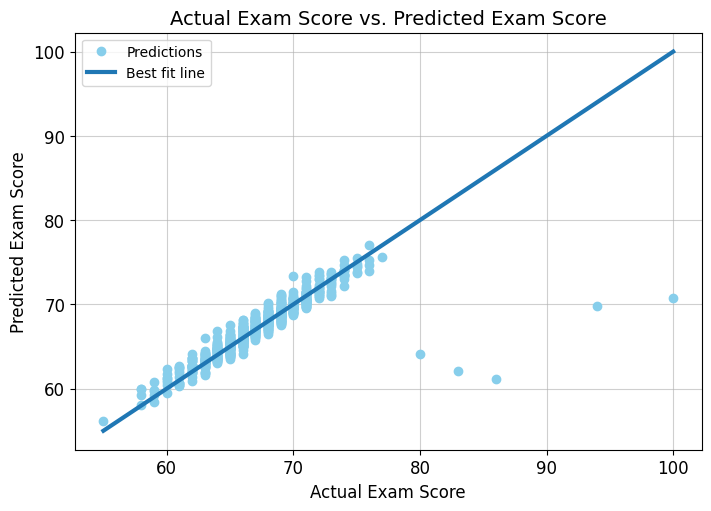

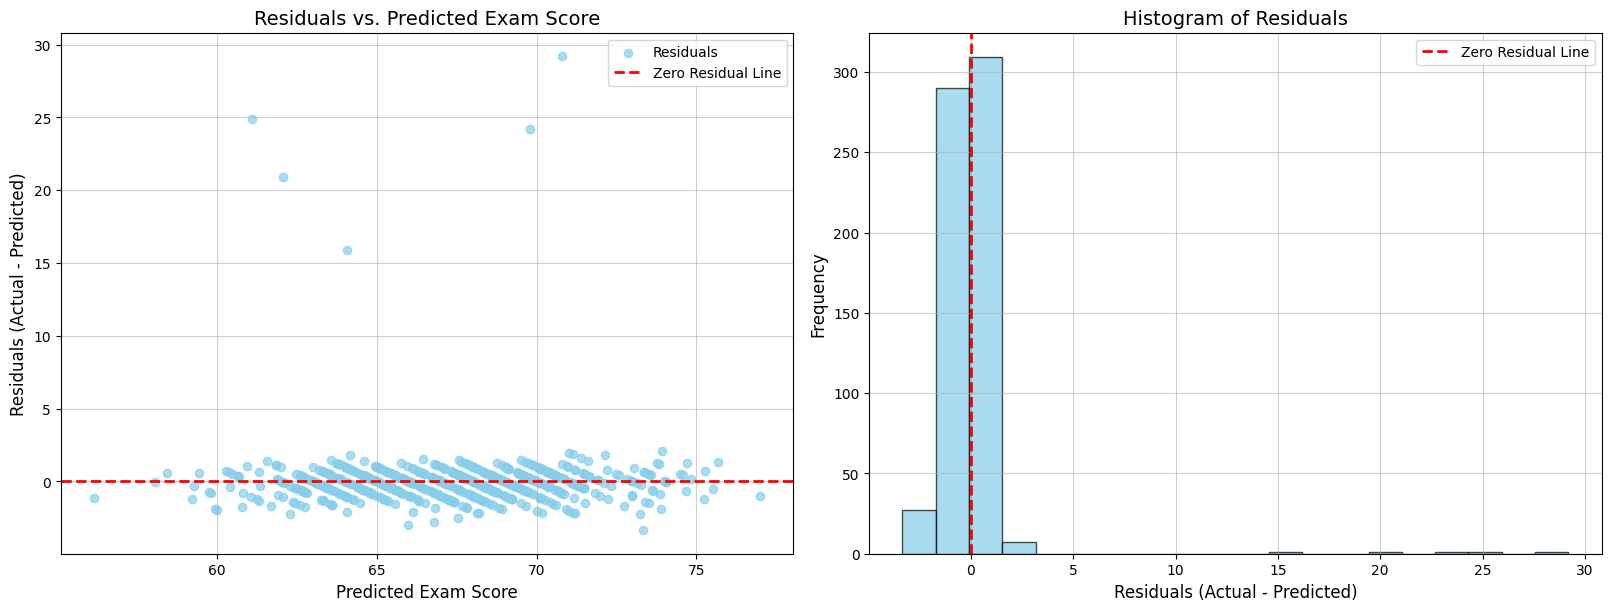

In [ ]:
# See how the model is doing on the test set
metrics1, metrics2 = evaluate_test_performance(y_test_pred=lr_output[3], y_test=y_test, X_test=X_test, plot_residuals=True)
print("Test Set Performance")
print_output(metrics1)
print("\nFiltered Metrics")
print_output(metrics2)

In [ ]:
# Evaluate the stability of the model
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X=X, y=student_performance_factors['Exam_Score'], standardize=False)
metrics_summary = evaluate_stability(student_performance_factors, selected_features, X_val, y_val)
print("Stability Metrics")
print_output(metrics_summary)

Stability Metrics
Median RMSE : 2.4814642132245033
Median MAE : 0.9288049079683988
Median MAD : 0.6003665087297385
Median Correlation : 0.7917083684891382


In [ ]:
# Retrieve a ranked list of the coefficients in order to determine feature importance
ranked_features = rank_features(coefficients=lr_output[1], selected_features=selected_features)
print("Feature Importance")
print(ranked_features)

Feature Importance
                    Feature  Coefficient  Absolute Importance
0                Attendance     2.306846             2.306846
1             Hours_Studied     1.748431             1.748431
2      Parental_Involvement     0.695244             0.695244
3       Access_to_Resources     0.693329             0.693329
4           Previous_Scores     0.677704             0.677704
5         Tutoring_Sessions     0.627687             0.627687
6             Family_Income     0.419116             0.419116
7          Motivation_Level     0.387613             0.387613
8  Parental_Education_Level     0.375404             0.375404


#Final Pipeline
To simply run linear regression on the model and obtain the validation set, cross-validation, and test set metrics, run the final_pipline function. This does not include unnecessary intermediate steps such as regularization.

In [ ]:
# Putting everything together in one pipeline, excluding intermediate steps which did not end up becoming
# included in the final model (e.g. regularization)
def final_pipeline():
  student_performance_factors_raw = load_data()
  student_performance_factors = clean_data(student_performance_factors_raw)
  student_performance_factors = preprocess_data(student_performance_factors)
  X = student_performance_factors.drop('Exam_Score', axis=1)
  X_train, X_val, X_test, y_train, y_val, y_test = split_data(X=X, y=student_performance_factors['Exam_Score'])
  selected_features = forward_selection(X_train, X_val, y_train, y_val, X)["Selected Features"]
  X = X[selected_features]
  X_train, X_val, X_test, y_train, y_val, y_test = split_data(X=X, y=student_performance_factors['Exam_Score'])
  lr_output = train_linear_regression(X_train, y_train, X_val, y_val, X_test, y_test)
  print("Linear Regression Validation Metrics:")
  print_output(lr_output[0])
  print("\nLinear Regression Coefficients:",lr_output[1])
  print("Linear Regression Intercept:", lr_output[2])
  cv_output = k_fold_cross_validation(X_train, y_train, 10)
  print("\nK-Fold Cross Validation Output:")
  print_output(cv_output)
  test_metrics, test_metrics_filtered = evaluate_test_performance(y_test_pred=lr_output[3], y_test=y_test,
                                                                  X_test=X_test, plot_residuals=False)
  print("\nTest Set Performance")
  print_output(test_metrics)
  print("\nFiltered Metrics (Outliers Excluded)")
  print_output(test_metrics_filtered)
  ranked_features = rank_features(coefficients=lr_output[1], selected_features=selected_features)
  print("\nFeature Importance")
  print(ranked_features)


Linear Regression Validation Metrics:
rMSE : 2.482562288561816
MAE : 0.9228809294748044
MAD : 0.5933376130777788
Corr : 0.7914841383487888
R2 : 0.6260948246916216

Linear Regression Coefficients: [1.74843126 2.30684575 0.69524443 0.69332883 0.67770427 0.3876134
 0.62768738 0.41911578 0.37540445]
Linear Regression Intercept: 67.24148745519713

K-Fold Cross Validation Output:
rMSE : 2.1155625536250793
MAE : 0.8446848663517699
R^2 : 0.7182905763739144

Test Set Performance
rMSE : 2.2502444120704816
MAE : 0.8651759585832027
MAD : 0.5818509948801349
Corr : 0.8277510305821258
R2 : 0.6850891385711877

Filtered Metrics (Outliers Excluded)
Filtered rMSE : 0.8710835321439104
Filtered MAE : 0.690079560788828
Filtered MAD : 0.5704484560948799
Filtered Correlation : 0.9694494992893066
Filtered R^2 : 0.9375726015426734
Outliers Removed : 5 out of 638

Feature Importance
                    Feature  Coefficient  Absolute Importance
0                Attendance     2.306846             2.306846
1      

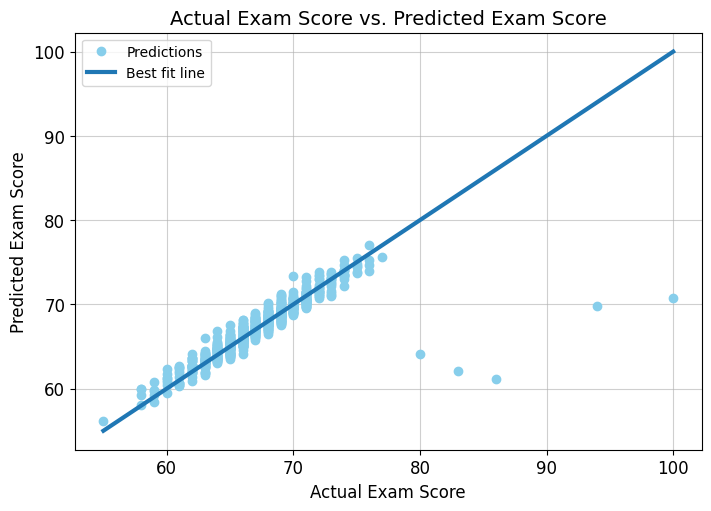

In [ ]:
final_pipeline()